In [1]:
from MakeBallBounceSetup import MakeManipulationStation
# Imports
import numpy as np
import altair as alt
import pydot
import matplotlib.pyplot as plt
from IPython.display import display, SVG, clear_output
import plotly.express as px
import matplotlib.patches as mpatches

from pydrake.all import (
    AddMultibodyPlantSceneGraph, AngleAxis, BasicVector, 
    DiagramBuilder, FindResourceOrThrow, Integrator, JacobianWrtVariable, 
    LeafSystem, MeshcatVisualizerCpp, MultibodyPlant, MultibodyPositionToGeometryPose, Parser,
    PiecewisePose, PiecewisePolynomial, Quaternion, RigidTransform, 
    RollPitchYaw, RotationMatrix, SceneGraph, Simulator, TrajectorySource,sin,cos
)
from pydrake.examples.manipulation_station import ManipulationStation
from BounceHelper import Optimizer2d, PseudoInverseController

from manipulation.meshcat_cpp_utils import (
    StartMeshcat, AddMeshcatTriad)
from manipulation.scenarios import AddMultibodyTriad, SetColor

# TODO(russt): Move this to drake (adding the element name support to the base class).
import pandas as pd
def dataframe(trajectory, times, names):
  assert trajectory.rows() == len(names)
  values = trajectory.vector_values(times)
  data = {'t': times }
  for i in range(len(names)):
    data[names[i]] = values[i,:]
  return pd.DataFrame(data)

In [2]:
meshcat = StartMeshcat()

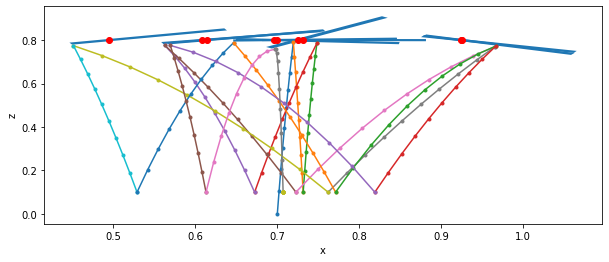

In [3]:
N=10
g=9.81
h,q_m,q_mdot,q_b,q_bdot = Optimizer2d(N)

#Plot the solution
fig, ax = plt.subplots(figsize=(10,4))
ax.set_xlabel('x')
ax.set_ylabel('z')

relative_time = np.linspace(0, 1, 10)

x_start=q_b[0,0]
z_start=0
for i in range(N):
    t = h[0,i]*relative_time
    x = x_start+ q_bdot[0,i]*t
    z = z_start + q_bdot[1,i]*t - .5*g*t*t
    ax.plot(x, z, '.-')
    x_start = x[-1]
    z_start = z[-1]

    if i is not N-1:
        t = h[1,i]*relative_time
        x = x_start+ q_mdot[3,i]*t
        z = z_start + q_mdot[4,i]*t - .5*g*t*t
        x_m = q_m[0,i]
        y_m = q_m[1,i]
        theta_m = q_m[2,i]

       
        Normal = np.array([sin(theta_m),-cos(theta_m)])
        tangent =  np.array([cos(theta_m),sin(theta_m)])

        pos = [x_m,y_m] + Normal*.005 - tangent*0.05
        
        ax.plot(x, z, '.-')
        ax.plot(x_m,y_m,'ro')
        tangent = np.array([])
     
        ax.add_patch(mpatches.Rectangle(pos,.2,.01,angle=theta_m*180/np.pi))
        x_start = x[-1]
        z_start = z[-1]

times = np.cumsum(np.sum(h,axis=0))


In [4]:
meshcat.Delete()

builder = DiagramBuilder()
diag, plant = MakeManipulationStation()
station = builder.AddSystem(diag)



temp_context = station.CreateDefaultContext()

#display(SVG(pydot.graph_from_dot_data(plant.GetTopologyGraphvizString())[0].create_svg()))
temp_plant_context = plant.GetMyContextFromRoot(temp_context)

plant.SetPositions(temp_plant_context, plant.GetModelInstanceByName("iiwa7"), [0, np.pi/3, 0, -np.pi/2, 0, -np.pi/3, 0])

#Path trajectory
X_G = plant.EvalBodyPoseInWorld(temp_plant_context, plant.GetBodyByName("base_link"))

x = X_G.translation()
r = X_G.rotation()

rz= RollPitchYaw(r).pitch_angle()

newTheta = q_m[2,:]*-1

newTime = np.concatenate(([0],times))*1
#print(newTheta.shape)
finalQ_m = np.concatenate((q_m[0:2,:],[newTheta]),axis =0)-[[0],[.5],[0]]

propr_der= np.concatenate(([[x[0]],[x[2]],[rz]],finalQ_m),axis =1)

v_dot = np.concatenate(([[0],[0],[0]],q_mdot[0:3,:]),axis=1)

poly = PiecewisePolynomial.CubicHermite(newTime,propr_der,v_dot)

traj_v_G = poly.MakeDerivative()

#This is connecting the trajectory source to the controller
v_G_source = builder.AddSystem(TrajectorySource(traj_v_G))
v_G_source.set_name("v_WG")

controller = builder.AddSystem(PseudoInverseController(plant))
controller.set_name("PseudoInverseController")
builder.Connect(v_G_source.get_output_port(), controller.GetInputPort("v_WG"))

integrator = builder.AddSystem(Integrator(7))
integrator.set_name("integrator")

builder.Connect(controller.get_output_port(), 
                integrator.get_input_port())
builder.Connect(integrator.get_output_port(),
                station.GetInputPort("iiwa_position"))
builder.Connect(station.GetOutputPort("iiwa_position_measured"),
                controller.GetInputPort("iiwa_position"))

visualizer = MeshcatVisualizerCpp.AddToBuilder(
    builder,station.GetOutputPort("geometry_query"), meshcat)

diagram = builder.Build()
diagram.set_name("Ball_Bouncer")

simulator = Simulator(diagram)

station_context = diagram.GetMyContextFromRoot(simulator.get_mutable_context())
plant_context = diagram.GetSubsystemContext(plant,station_context)

_iiwa = plant.GetModelInstanceByName("iiwa7")
plant.SetPositions(plant_context, plant.GetModelInstanceByName("iiwa7"), [0, np.pi/3, 0, -np.pi/2, 0, -np.pi/3, 0])

integrator.GetMyContextFromRoot(simulator.get_mutable_context()).get_mutable_continuous_state_vector().SetFromVector(plant.GetPositions(plant_context,_iiwa))





#visualizer.start_recording()

AddMeshcatTriad(meshcat,"InitialPose",X_PT=X_G)
simulator.set_target_realtime_rate(.1)
simulator.AdvanceTo(.01)
##visualizer.stop_recording()
#isualizer.publish_recording()




In [5]:
val = 0
#draw all of the poses here to sanity check stuff
for i in propr_der.T:
    val = val +1
    w = RotationMatrix.MakeYRotation(i[2])
    r = [i[0],0,i[1]] 
    AddMeshcatTriad(meshcat,"pos/"+ str(val),length = .15,radius = .006,X_PT=RigidTransform(w,r)) 

In [6]:
data = dataframe(poly, np.linspace(poly.start_time(), poly.end_time()), ['x','y','z'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
)

alt.VConcatChart(...)

In [7]:
data = dataframe(traj_v_G, np.linspace(traj_v_G.start_time(), traj_v_G.end_time()), ['x','y','z'])
alt.vconcat(
  alt.Chart(data).mark_line().encode(x='t', y='x').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='y').properties(height=80),
  alt.Chart(data).mark_line().encode(x='t', y='z').properties(height=80),
)

alt.VConcatChart(...)

In [8]:
simulator.AdvanceTo(4)